# DCGAN
Architecture adapted from:
### 1. https://www.tensorflow.org/tutorials/generative/dcgan

Deep Convolutional GAN or DCGAN explicitly uses convolutional and transpose-convolutional layers in the discriminator and generator, making it Unidirectional. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. the amount of time it takes to run this model, the output images are not as impressive.


### Authors : Gopalika Sharma and Surya Menon

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)


Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

Monet TFRecord Files: 5


In [3]:
IMAGE_SIZE = [256, 256]

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.reshape(image, [256, 256, 3])
    image = tf.image.decode_jpeg(image, channels=3)
    #image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3 
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    return image

def flip(image):
    return tf.image.flip_left_right(image)

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(100000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(100000)
    return dataset

### Loading DATA

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, repeats=100).batch(100, drop_remainder=True)

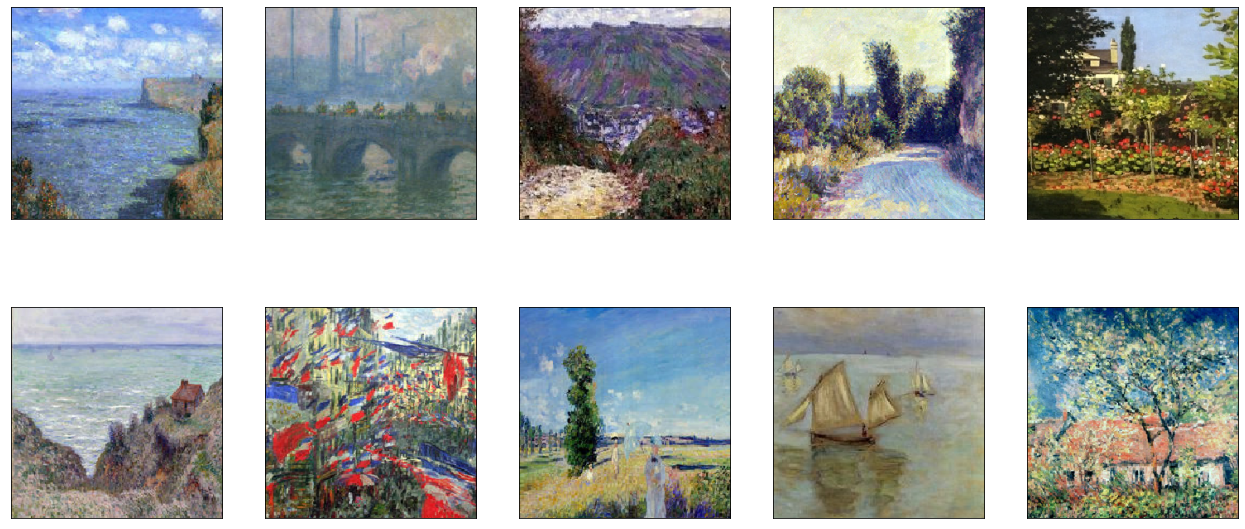

In [5]:
def view_image(ds, rows=2):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5)

view_image(monet_ds)

In [6]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
    #different values of stddev
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    result.add(layers.MaxPool2D())

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [7]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
    #different values of stddev
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    #change the stride convolutional layers as 2,3,4
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.LeakyReLU())

    return result

### Changes EPOCH, smaple size, Latent dimension and replace adam with gradient descent optimiser.

In [8]:
def Generator(LATENT_DIM=128, OUTPUT_CHANNELS=3):
    inputs = layers.Input(shape=[LATENT_DIM,])

    up_stack = [
        upsample(LATENT_DIM, 4, apply_dropout=True), 
        upsample(LATENT_DIM, 4, apply_dropout=True), 
        upsample(LATENT_DIM//2, 4), 
        upsample(LATENT_DIM//4, 4), 
        upsample(LATENT_DIM//8, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)
    q = 4
    x = layers.Dense(q * q * LATENT_DIM)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((q, q, LATENT_DIM))(x)

    # Upsampling 
    for up in up_stack:
        x = up(x)

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x, name="generator")

In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    #down3 = downsample(512, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)#RELU, ELU

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last_conv = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation='sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
with strategy.scope():
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        gen_loss  = tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2)
        real_loss = tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2)
        return (gen_loss + real_loss) / 2
    
    def generator_loss(predictions_real, predictions_gen, labels_real):
        gen_loss  = tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)
        real_loss = tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2)
        return (gen_loss + real_loss) / 2

In [11]:
LATENT_DIM = 128
# 256

with strategy.scope():
    monet_generator = Generator(LATENT_DIM, 3) # generates Monet-esque paintings
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings

In [12]:
class MonetGan(keras.Model):
    def __init__(self, monet_generator, monet_discriminator, latent_dim, real_label=0.5, fake_label=0):
        super(MonetGan, self).__init__()
        self.generator = monet_generator
        self.discriminator = monet_discriminator
        self.latent_dim = latent_dim
        self.real_label = real_label
        self.fake_label = fake_label
        
    def compile(self, d_opt, g_opt, d_loss_fn, g_loss_fn):
        super(MonetGan, self).compile()
        self.d_opt = d_opt
        self.g_opt = g_opt
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    def train_step(self, images_real):
        if isinstance(images_real, tuple):
            images_real = images_real[0]
        
        # Sample random points in the latent space
        batch_size = tf.shape(images_real)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # labels_gen  = tf.fill((batch_size, 1), self.fake_label)
        # labels_real = tf.fill((batch_size, 1), self.real_label)
        
        labels_gen  = tf.zeros((batch_size, 1)) + self.fake_label
        labels_real = tf.zeros((batch_size, 1)) + self.real_label
        
        # Add random noise to the labels - important trick!
        labels_gen  += 0.05 * tf.random.uniform(tf.shape(labels_gen))
        labels_real += 0.05 * tf.random.uniform(tf.shape(labels_real))
        
        with tf.GradientTape() as d_tape:
            # Train the generator
            images_gen = self.generator(random_latent_vectors, training=False)
            
            # Train the discriminator
            predictions_real = self.discriminator(images_real, training=True)
            predictions_gen  = self.discriminator(images_gen, training=True)
            d_loss = self.d_loss_fn(predictions_real, predictions_gen, labels_real)
            
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))        
        
        with tf.GradientTape() as g_tape:
            # Train the generator
            images_gen = self.generator(random_latent_vectors, training=True)
            
            # Train the discriminator
            predictions_real = self.discriminator(images_real, training=False)
            predictions_gen  = self.discriminator(images_gen, training=False)
                        
            # Calculate loss LSGan
            # g_loss = (tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2) +
            #           tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2))/2
            
            g_loss = self.g_loss_fn(predictions_real, predictions_gen, labels_real)
        
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

In [13]:
EPOCHS = 50
# 100,150

LR_G = 0.001
LR_D = 0.0005
beta_1 = .5

real_label = .66
fake_label = 0

with strategy.scope():
    monet_gan = MonetGan(monet_discriminator=monet_discriminator, 
                         monet_generator=monet_generator, 
                         latent_dim=LATENT_DIM,
                         real_label=real_label,
                         fake_label=fake_label)
    
    monet_gan.compile(
        d_opt = tf.keras.optimizers.Adam(learning_rate=LR_D, beta_1=beta_1),
        g_opt = tf.keras.optimizers.Adam(learning_rate=LR_G, beta_1=beta_1),
        d_loss_fn=discriminator_loss,
        g_loss_fn=generator_loss
    )

In [14]:
monet_gan.fit(
    monet_ds,
    epochs=EPOCHS,
)

Epoch 1/50
606/606 [==============================] - 77s 128ms/step - d_loss: 0.0465 - g_loss: 1.8877
Epoch 2/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0508 - g_loss: 1.9261
Epoch 3/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0511 - g_loss: 1.9105
Epoch 4/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0565 - g_loss: 1.8578
Epoch 5/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0511 - g_loss: 1.8829
Epoch 6/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0526 - g_loss: 1.8880
Epoch 7/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0540 - g_loss: 1.8919
Epoch 8/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0607 - g_loss: 1.8615
Epoch 9/50
606/606 [==============================] - 77s 127ms/step - d_loss: 0.0558 - g_loss: 1.9048
Epoch 10/50
606/606 [==============================] - 77s 127ms/step - d

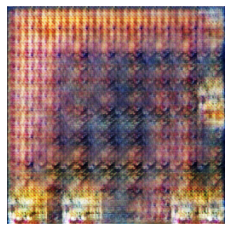

In [19]:
#only zip 500 images for output submission file
#changing the value of latent dimension in earlier cells
for i in range(500):
    prediction = monet_generator(np.random.randn(1, LATENT_DIM), training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    plt.imshow(prediction)
    #plt.set_title("Monet-esque")
    plt.axis("off")
plt.show()

### Not a good style transfer in DCGAN, image  is untelligible.

In [ ]:
import PIL
! mkdir ../images

In [ ]:
for i in range(10000):
    prediction = monet_generator(np.random.randn(1, LATENT_DIM), training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(f"../images/{i}.jpg")


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")